In [1]:
!pip install pandasql

In [2]:
!pip install SQLAlchemy==1.4.17

# Задание 1

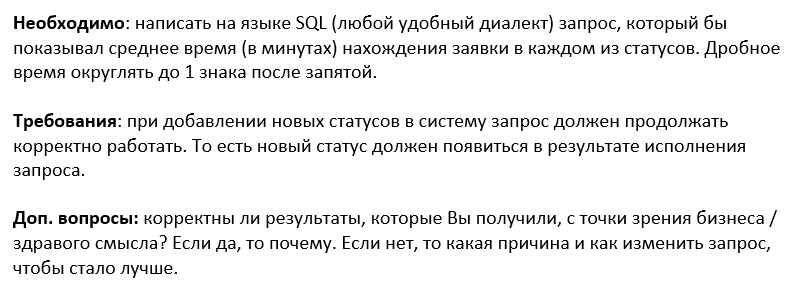

In [3]:
import pandas as pd
import numpy as np
import os
import pandasql as ps
from sklearn import datasets
from sqlalchemy import text
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
# сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# сброс ограничений на число строк
pd.set_option('display.max_rows', None)
# ширина коронки
pd.options.display.max_colwidth = None

In [5]:
# чтение датасета
df = pd.read_csv('deal_status_updates_202207221218.csv', sep=';')
df.head(5)

,id,timestamp,status
0,55559,1656841243,Ожидает подтверждения
1,55559,1656841249,Ожидает оплаты
2,72941,1656871952,Заведение заказа в 1С
3,72903,1656871977,Заведение заказа в 1С
4,71843,1656872034,Заведение заказа в 1С


# Задание 1
Написать на языке SQL (любой удобный диалект) запрос, который бы показывал среднее время (в минутах) нахождения заявки в каждом из статусов. Дробное время округлять до 1 знака после запятой.

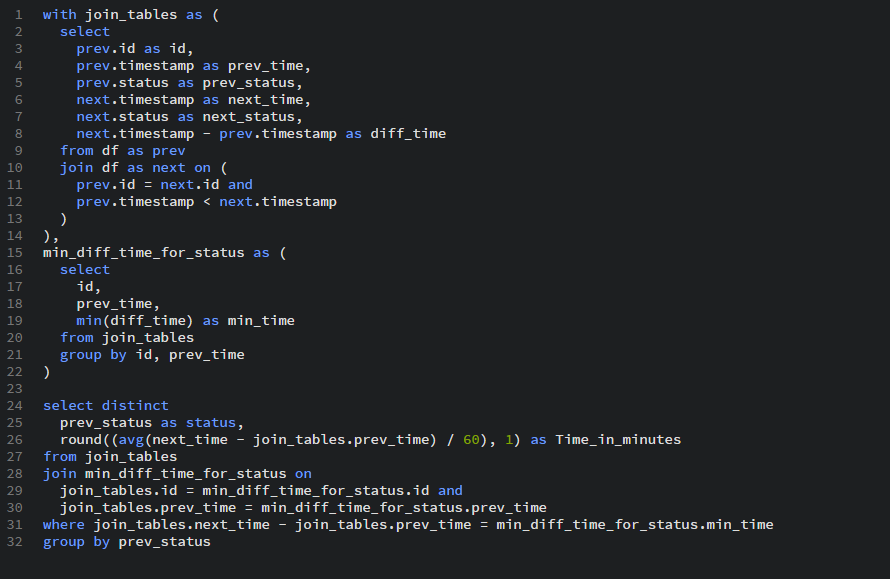

Выполнение запроса:

In [6]:
query = '''

with join_tables as (
  select
    prev.id as id,
    prev.timestamp as prev_time,
    prev.status as prev_status,
    next.timestamp as next_time,
    next.status as next_status,
    next.timestamp - prev.timestamp as diff_time
  from df as prev
  join df as next on (
    prev.id = next.id and
    prev.timestamp < next.timestamp
  )
),
min_diff_time_for_status as (
  select
    id,
    prev_time,
    min(diff_time) as min_time
  from join_tables
  group by id, prev_time
)

select distinct
  prev_status as status,
  round((avg(next_time - join_tables.prev_time) / 60), 1) as Time_in_minutes
from join_tables
join min_diff_time_for_status on
  join_tables.id = min_diff_time_for_status.id and
  join_tables.prev_time = min_diff_time_for_status.prev_time
where join_tables.next_time - join_tables.prev_time = min_diff_time_for_status.min_time
group by prev_status

'''


df_query = ps.sqldf(query)
df_query

,status,Time_in_minutes
0,Заведение заказа в 1С,38.7
1,Ожидает подтверждения,0.1
2,Ожидание,307.8
3,Ожидание юр.лица,72.7
4,Проверка информации,32.2
5,Проверка товара на складе,337.1
6,Сбор информации,6.2
7,Согласование нового товара,60.2
8,Товар не устраивает,1002.7
9,Формирование счета для юр.лица,0.0


В данном случае многие статусы заявок не учитываются, потому что они были последними и не изменились к моменту формирования датасета.

Я думаю, эти данные могут быть корректны. Многие автоматические операции (ожидание подтверждения, формирование счета) выполняются практически мгновенно. Тогда как статус, для изменения которого нужно участие человека (проверка товара на складе, товар не устраивает), изменяется гораздо дольше. Но, например, время изменения статуса проверки товара на складе в среднем занимает около 5-ти часов. Можно посмотреть, почему именно это происходит.   

### Анализ времени проверки товара на складе

In [7]:
df_sort = df.sort_values(by = ['id', 'timestamp'])

In [8]:
# Добавим колонку time, в которой будет хранится дата и время
df_sort['full_time'] =  pd.to_datetime(df['timestamp'], unit='s')

In [9]:
# Разделим time на год, месяц, дату и время
df_sort['time'] = df_sort['full_time'].dt.time
df_sort['year'] = df_sort['full_time'].dt.year
df_sort['month'] = df_sort['full_time'].dt.month
df_sort['day'] = df_sort['full_time'].dt.day

In [10]:
# Удалим ненужные колонки
df_sort.drop(columns=['full_time'], axis=1, inplace=True)

In [11]:
df_sort['check'] = np.where((df_sort['status'] == 'Проверка товара на складе') & (df_sort['id'] == df_sort['id'].shift(-1)), 
                        (df_sort['timestamp'].shift(-1) - df_sort['timestamp'])/60,'')

Выведем преобразованные данные.  
В столбце check выводится время в минутах до изменения статуса заказа и следующая строчка, чтобы можно было убедиться, что считается время именно по тому же id.

In [12]:
df_for_graph = df_sort.loc[((df_sort['check'] != '') | (df_sort['check'].shift(1) != ''))].iloc[1:]
df_for_graph.head(6)

,id,timestamp,status,time,year,month,day,check
16,70661,1656872583,Проверка товара на складе,18:23:03,2022,7,3,1251.9166666666667
590,70661,1656947698,Сделка успешна,15:14:58,2022,7,4,
14,72947,1656872442,Проверка товара на складе,18:20:42,2022,7,3,948.9333333333333
134,72947,1656929378,Согласование нового товара,10:09:38,2022,7,4,
55,72951,1656875841,Проверка товара на складе,19:17:21,2022,7,3,1452.2
780,72951,1656962973,Согласование нового товара,19:29:33,2022,7,4,


In [13]:
# Удаление строк с пустыми значениями в столбце 'check'
df_filtered = df_sort[df_sort['check'] != ''].copy()

# Преобразование значений в числовой формат
df_filtered.loc[:, 'check'] = pd.to_numeric(df_filtered['check'])

# Выбор только строк с днем равным 4
df_filtered = df_filtered[df_filtered['day'] == 4]

# Сортировка по времени изменения заявки в реальном мире (timestamp)
df_filtered.sort_values(by='timestamp', inplace=True)

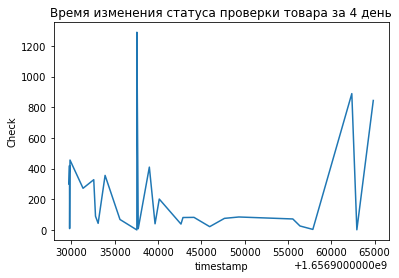

In [14]:
plt.plot(df_filtered['timestamp'], df_filtered['check'])
plt.xlabel('timestamp')
plt.ylabel('Check')
plt.title('Время изменения статуса проверки товара за 4 день')
plt.show()

Видно, что в середине дня есть какой-то выброс, который нужно рассмотреть отдельно.  
Но в целом, под конец дня время изменения статуса заявки сильно увеличивается. Это может быть связано с тем, что мы никак не учитываем график работы магазина и статус заявки может измениться только на следующий день.

# Задание 2

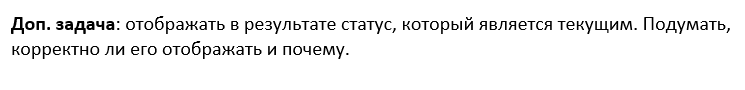

Отображать в результате статус, который является текущим. Подумать, корректно ли его отображать и почему.

В данном случае нужно будет разбить запрос на несколько, чтобы была возможность корректно заполнить пропущенные данные

In [15]:
join_tables = '''

select
    prev.id as id,
    prev.timestamp as prev_time,
    prev.status as prev_status,
    next.timestamp as next_time,
    next.status as next_status,
    next.timestamp - prev.timestamp as diff_time
from df as prev
left join df as next on (
    prev.id = next.id and
    prev.timestamp < next.timestamp
    )

'''

join_tables = ps.sqldf(join_tables)

In [16]:
max_time = '''

select 
    max(diff_time) as max_time
from join_tables

'''

max_time = ps.sqldf(max_time)
max_time

,max_time
0,91912.0


Теперь вместо пропущенных значений времени можно вставлять максимальное время из данных

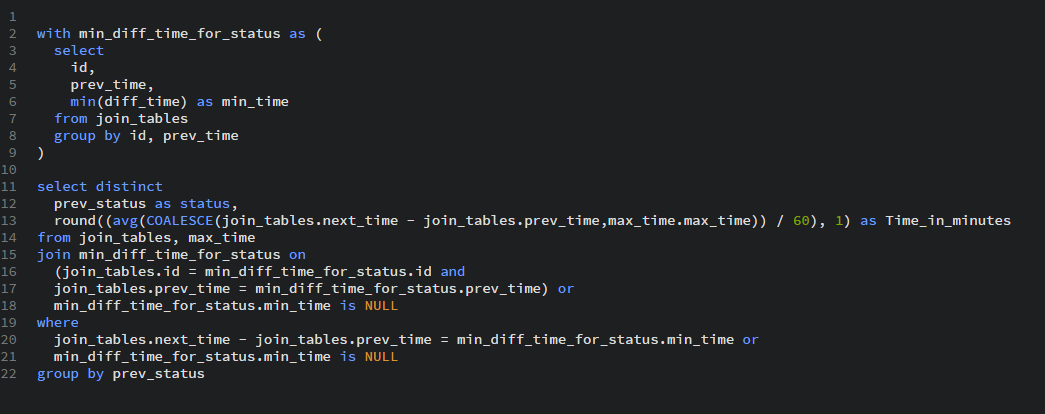

In [17]:
query_2 = '''

with min_diff_time_for_status as (
  select
    id,
    prev_time,
    min(diff_time) as min_time
  from join_tables
  group by id, prev_time
)

select distinct
  prev_status as status,
  round((avg(COALESCE(join_tables.next_time - join_tables.prev_time,max_time.max_time)) / 60), 1) as Time_in_minutes
from join_tables, max_time
join min_diff_time_for_status on
  (join_tables.id = min_diff_time_for_status.id and
  join_tables.prev_time = min_diff_time_for_status.prev_time) or
  min_diff_time_for_status.min_time is NULL
where
  join_tables.next_time - join_tables.prev_time = min_diff_time_for_status.min_time or
  min_diff_time_for_status.min_time is NULL
group by prev_status

'''

df_query_2 = ps.sqldf(query_2)
df_query_2

,status,Time_in_minutes
0,Артикул уже продан,1531.9
1,Возврат,1531.9
2,Доставка. Далеко до терминала ТК,1531.9
3,Доставка. Неудобный интервал,1531.9
4,Доставка. Нужны выбор и осмотр,1531.9
5,Доставка. Товар нужен сегодня,1531.9
6,Дубль,1531.9
7,Заведение заказа в 1С,234.4
8,Истекло время ожидания,1531.9
9,Не устраивает цена,1531.9


Я думаю, отображать в результате статус, который является текущим не нужно.   
Значения не отображают действительность, к тому же результат сильно смещается.